In [146]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm_notebook

from src.onset_detection import OnsetDetection

In [147]:
DATA_PATH = Path('./data/')

df_description = pd.DataFrame()
signals = None


for i, path in enumerate(sorted(DATA_PATH.glob('*.data'))):
    with open(path, 'rb') as file:
        loaded = pd.read_pickle(file)

        loaded_description = loaded[0]
        loaded_description['class'] = i+1
        loaded_signals = loaded[1]

        df_description = pd.concat([df_description, loaded_description], ignore_index=True)
        if signals is None: 
            signals = loaded_signals
        else: 
            signals = np.concat([signals, loaded_signals])

In [148]:
signals.shape

(32008, 5120)

In [149]:
# class OnsetDetection():
#     def __init__(self, window_length=500, out_length=625, window_step=5, start_search=None, end_search=None, threshold=0.1, SNR=False, energy_gap=None) -> None:
        
#         self.out_length = out_length
#         self.window_length = window_length

#         self.threshold = threshold

#         self.window_step = window_step
#         self.search_start = start_search
#         self.search_end = end_search
        
#         # Fill the params if not set
#         if self.search_start is None:
#             self.search_start = window_length
#         if self.search_end is None:
#             self.search_end = self.search_start * 3

#         # Define the search range
#         self.search_range = range(self.search_start, self.search_end, self.window_step)    

#         # SNR picking
#         self.SNR = SNR
#         if SNR: 
#             if energy_gap is None: raise ValueError(f"With SNR picking energy gap cannot be set to {energy_gap}")
#             else: self.energy_gap = energy_gap


#     def _check_length(self, x):
#         self.input_length = len(x)
        
#         if self.input_length <= self.out_length:
#             raise ValueError(f'Input length cannot be smaller then output length and is: {self.input_length} and {self.out_length}')
        
#         if self.input_length <= self.window_length:
#             raise ValueError(f'Input length cannot be smaller then the selected window size and is: {self.input_length} and {self.window_length}')
        
#         if self.input_length < self.search_end:
#             raise ValueError(f'Input length cannot be smaller then the searched area and is: {self.input_length} and {self.search_end}')
        
#         return

#     def _calculate_moment_6(self, x, moment_1, moment_2):
        
#         # Prealocation
#         moment_6 = []

#         # Loop through the windows in search range
#         for n, i in enumerate(self.search_range): 

#             # Get the waveform piece of the window
#             x_i = x[i-self.window_length:i]

#             # Calculate the fraction nom and denom
#             nom = np.sum((x_i - moment_1[n]) ** 6)
#             denom = ((self.window_length - 1) * (moment_2[n] ** 3))

#             moment_6.append(nom/denom - 15)

#         return moment_6
    

#     def _first_positive_index(self, x, threshold=0):
#         """Finds the first index above threshold"""


#         # Find where the values are positive
#         positive_indices = np.where(x > threshold)[0]
        
#         # Check if there is any positive value
#         if positive_indices.size == 0:
#             return None  # or raise an exception, or return a specific value like -1
        
#         # Return the index of the first positive value
#         return positive_indices[0]

#     def __call__(self, x):
        
#         # Make sure the input is an array
#         x = np.asarray(x).astype(int)

#         # Check if the length is correct
#         self._check_length(x)

#         # Calculate statistical moments based on waveform pieces
#         moment_1 = [np.mean(x[i-self.window_length:i], dtype=float) for i in self.search_range]
#         moment_2 = [np.var(x[i-self.window_length:i], dtype=float) for i in self.search_range]
#         moment_6 = self._calculate_moment_6(x, moment_1, moment_2)

#         # Get the change rate (absolute)
#         d_moment_6 = np.abs(np.gradient(moment_6))

#         # Get threshold
#         threshold = self.threshold * np.nanmax(d_moment_6)

#         # Find the first index above threshold and adapt it to the search area
#         onset_index = self._first_positive_index(d_moment_6, threshold)
#         onset_index = onset_index*self.window_step + self.search_start

#         # Short waveform
#         out = x[onset_index:onset_index+self.out_length]

#         # Signal to noise ratio picking
#         if self.SNR:
#             pass # TODO: finish the SNR picking


#         return onset_index, out

In [150]:
od = OnsetDetection(window_step=10)

In [151]:
# fig, ax = plt.subplots(2, figsize=(10, 10))

# sig = signals[200]

# ind, short = od(sig)
# threshold = od.threshold*np.nanmax(test)

# ax[0].plot(range(od.search_start, od.search_end), sig[od.search_start: od.search_end])
# #ax[0].plot(range(ind, ind+od.out_length), short)
# ax[0].axvline(ind, c='r')

# ax[1].plot(od.search_range, test)
# ax[1].axhline(threshold, c='r', linestyle=':')


In [152]:
out_size = 512
od = OnsetDetection(window_step=10, out_length=out_size)
short_signals = np.empty((len(signals), 512))

for i in tqdm_notebook(range(len(signals))):
    

    _, short_sig = od(signals[i])

    short_signals[i, :] = short_sig

  0%|          | 0/32008 [00:00<?, ?it/s]

In [153]:
short_signals.shape

(32008, 512)

(129, 335)

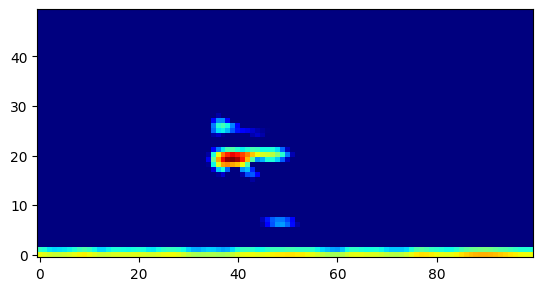

In [224]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

# Step 1: Generate a sample signal
signal = signals[16000]
signal = signal / np.max(signal) 

fs = 4*1e9  # Sampling frequency
t = np.arange(len(signal)) / fs  # Time vector

w = gaussian(256, std=32, sym=True)  # symmetric Gaussian window

# A sample signal: sum of two sine waves with different frequencies


# Step 2: Compute the Short-Time Fourier Transform (STFT)
STF = ShortTimeFFT(w, hop=16, fs=fs, scale_to='psd')
Sx = STF.spectrogram(signal)

Sx = 10 * np.log10(np.fmax(Sx, 1e-10))  # limit range to -40 dB

im1 = plt.imshow(Sx[0:50, 50:150], origin='lower', cmap='jet')
# # Step 3: Plot the STFT magnitude
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
# plt.title('STFT Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar(label='Magnitude')
# plt.show()

Sx.shape

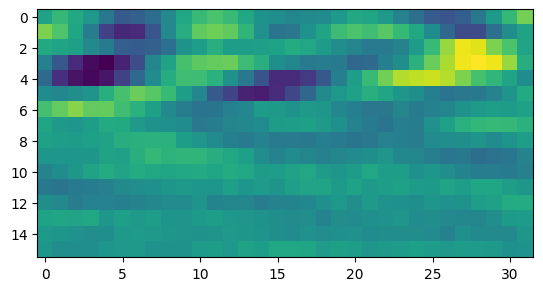

In [213]:
plt.imshow(short_signals[3000].reshape(16, 32))

In [178]:
np.std(short_signals[1])

np.float64(137.0934538115238)

In [156]:
np.abs(Zxx).shape

(129, 80)

In [157]:
t.size

512